In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
from typing import Union

from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product

warnings.filterwarnings("ignore")
%matplotlib inline

we will examine the autoregressive moving average process, ARMA(p,q), where p denotes the order of the autoregressive portion and q denotes the order of the moving average portion. Furthermore, using the ACF and PACF plots to determine the orders q and p, respectively, becomes difficult, as both plots will show either a slowly decaying or sinusoidal pattern. Thus, we will define a general modeling procedure that will allow us to model such complex time series. This procedure involves model selection using the Akaike information criterion (AIC), which will determine the optimal combination of p and q for our series. Then we must evaluate the model’s validity using residual analysis by studying the correlogram, Q-Q plot, and density plot of the model’s residuals to assess if they closely resemble white noise. If that is the case, we can move on to forecasting our time series using the ARMA(p,q) model.

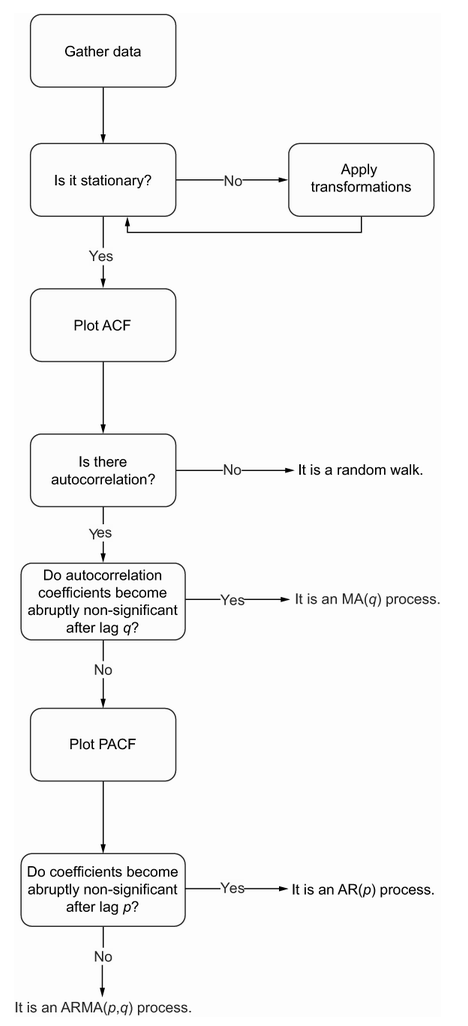

keep in mind that the function expects to have the coefficient of the autoregressive process with its opposite sign, as this is how it is implemented in the statsmodels library. Therefore, we input it as–0.33. For the moving average portion, specifies that the coefficient is 0.9

In [2]:
np.random.seed(42)

ar1=np.array([1,-0.33])
ma1=np.array([1,0.9])

sim_data=ArmaProcess(ar1,ma1).generate_sample(nsample=1000)

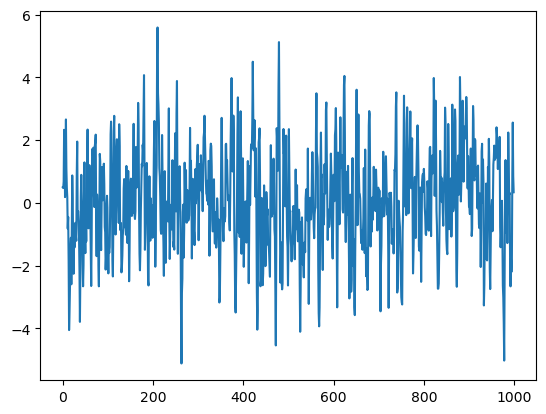

In [3]:
plt.plot(sim_data)

In [4]:
#testing for stationarity
val=adfuller(sim_data)
print('adf_value: ',val[0],'   p-value: ',val[1])

adf_value:  -6.429878682042678    p-value:  1.707846668009813e-08


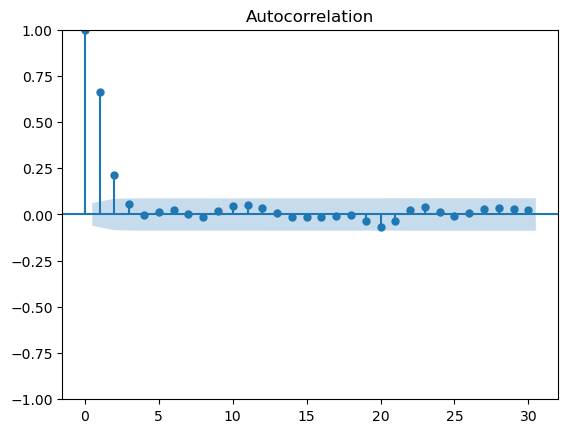

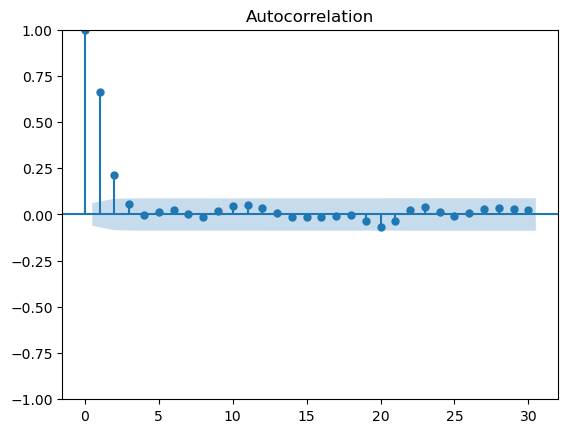

In [5]:
plot_acf(sim_data)

ACF plot of our simulated ARMA(1,1) process. Notice the sinusoidal pattern on the plot, meaning that an AR(p) process is in play. Also, the last significant coefficient is at lag 2, which suggests that q = 2. However, we know that we simulated an ARMA(1,1) process, so q must be equal to 1! Therefore, the ACF plot cannot be used to infer the order q of an ARMA(p, q) process.

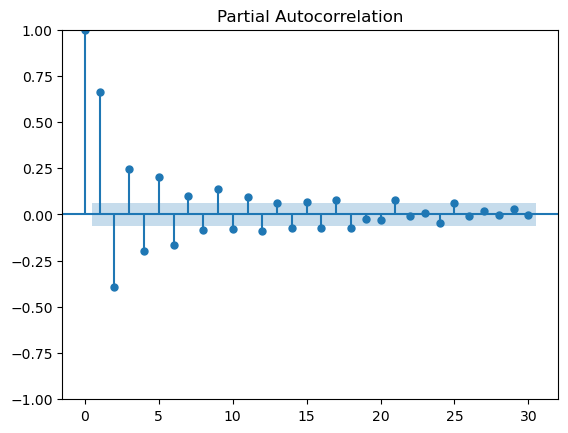

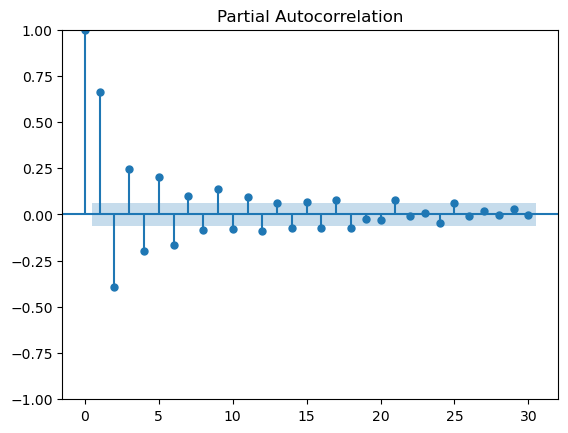

In [6]:
plot_pacf(sim_data)

PACF plot of our simulated ARMA(1,1) process. Again, we have a sinusoidal pattern with no clear cutoff between significant and non-significant coefficients. From this plot, we cannot infer that p = 1 in our simulated ARMA(1,1) process, meaning that we cannot determine the order p of an ARMA(p, q) process using a PACF plot.

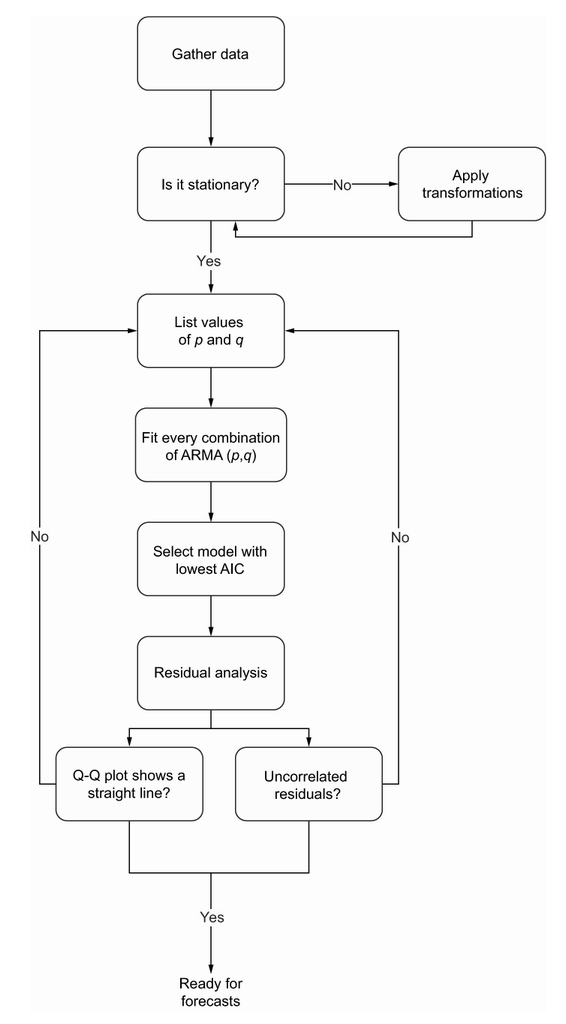

# AIC

The Akaike information criterion (AIC) is a measure of the quality of a model in relation to other models. It is used for model selection.

The AIC is a function of the number of parameters k in a model and the maximum value of the likelihood function L̂:

AIC 2k – 2ln(L̂)

The lower the value of the AIC, the better the model. Selecting according to the AIC allows us to keep a balance between the complexity of a model and its goodness of fit to the data.

The number of estimated parameters k is directly related to the order (p,q) of an ARMA(p,q) model. If we fit an ARMA(2,2) model, then we have 2 + 2 = 4 parameters to estimate. If we fit an ARMA(3,4) model, then we have 3 + 4 = 7 parameters to estimate. You can see how fitting a more complex model can penalize the AIC score: as the order (p,q) increases, the number of parameters k increases, and so the AIC increases.

The likelihood function measures the goodness of fit of a model. It can be viewed as the opposite of the distribution function. Given a model with fixed parameters, the distribution function will measure the probability of observing a data point. The likelihood function flips the logic. Given a set of observed data, it will estimate how likely it is that different model parameters will generate the observed data.

You can see how the AIC keeps a balance between underfitting and overfitting. Remember that the lower the AIC, the better the model relative to other models. Therefore, an overfitting model would have a very good fit, meaning that L̂ is large and AIC decreases. However, the number of parameters k would be large as well, which penalizes the AIC. An underfitting model would have a small number of parameters, so k would be small. However, the maximum value of the likelihood function would also be small due to the poor fit, meaning again that the AIC is penalized. Thus, the AIC allows us to find a balance between the number of parameters in a model and a good fit to the training data.

In [7]:
ps=range(0,4)
qs=range(0,4)

orders=list(product(ps,qs))

In [8]:
def get_good_p_q(df,list_order):
    results=[]
    for i in list_order:
        try:
            model=SARIMAX(endog=df,order=(i[0],0,i[1]),simple_differencing=False).fit(disp=False)
        except:
            continue
        
        aic=model.aic
        results.append([i,aic])
        
    result_df = pd.DataFrame(results)                      
    result_df.columns = ['(p,q)', 'AIC']                   
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC',ascending=True).reset_index(drop=True)                  
    
    return result_df

In [9]:
res=get_good_p_q(sim_data,orders)

In [10]:
res

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.163016
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


Resulting DataFrame from fitting all ARMA(p, q) models to the simulated ARMA(1,1) data. We can see that the model with the lowest AIC corresponds to an ARMA(1,1) model, meaning that we successfully identified the order of our simulated data.

# Resudial Analysis

In [11]:
model = SARIMAX(sim_data, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

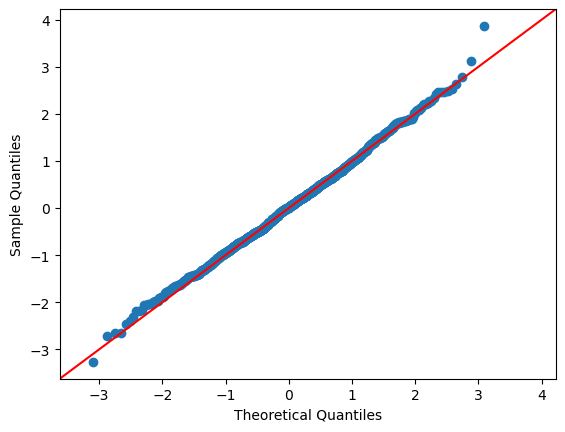

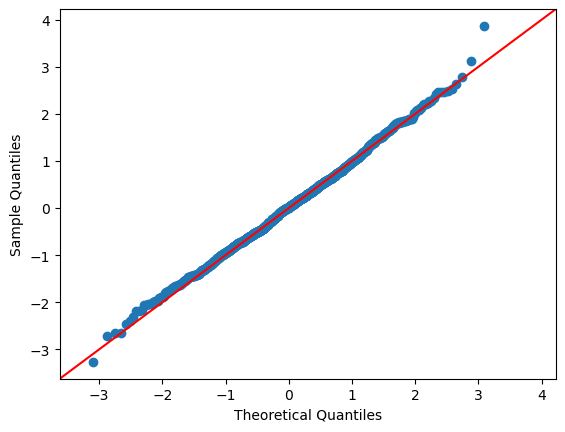

In [12]:
qqplot(residuals,line='45')

You can see a thick straight line lying on y = x. This means that our residuals are normally distributed, just like white noise.

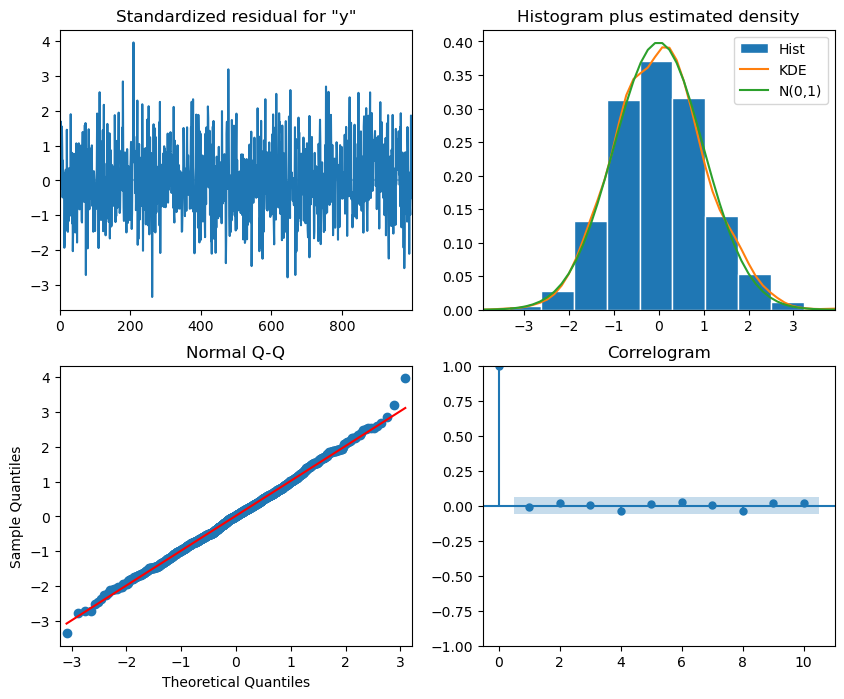

In [13]:
model_fit.plot_diagnostics(figsize=(10, 8));

The top-left plot displays the residuals, the histogram of the residuals is at the top right, the Q-Q plot of the residuals is at the bottom left, and the bottom right shows the ACF plot of the residuals.

# Now We have to do the quantitative analysis

The final step in residual analysis is applying the Ljung-Box test. This allows us to quantitatively assess whether our residuals are indeed uncorrelated. We will use the acorr_ljungbox function from statsmodels to perform the Ljung-Box test on the residuals. The function takes as input the residuals as well as a list of lags. Here we will compute the Ljung-Box statistic and p-value for 10 lags.

The resulting list of p-values shows that each is above 0.05. Therefore, at each lag, the null hypothesis cannot be rejected, meaning that the residuals are independently distributed and uncorrelated.

here we should make sure that the each valu should be higher the the p value then only we can conclude that theya re uncorellated

In [14]:
test_resu=acorr_ljungbox(residuals, np.arange(1, 11, 1))
test_resu

,lb_stat,lb_pvalue
1,0.030706,0.860897
2,0.528021,0.767966
3,0.540904,0.909817
4,2.079774,0.721089
5,2.271897,0.810385
6,2.896262,0.821750
7,2.900378,0.894063
8,4.418799,0.817501
9,4.787567,0.852419
10,5.246805,0.874093


here we can know that pvalue is higher then the 0.05

# Now applying the above procedure on the real dataset

In [15]:
data=pd.read_csv('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/bandwidth.csv')

In [16]:
data.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


In [17]:
test_res=adfuller(data['hourly_bandwidth'])
print(test_res[0],test_res[1])

-0.8714653199452729 0.7972240255014553


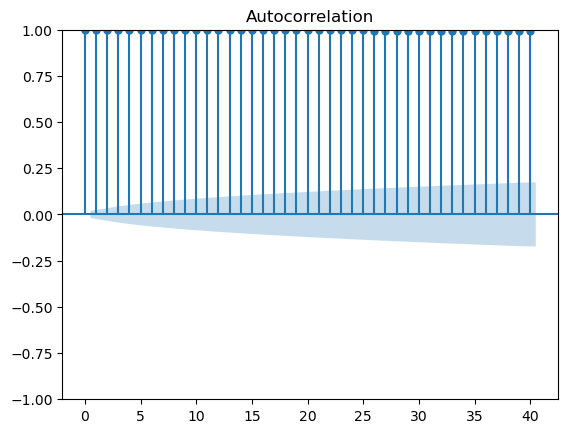

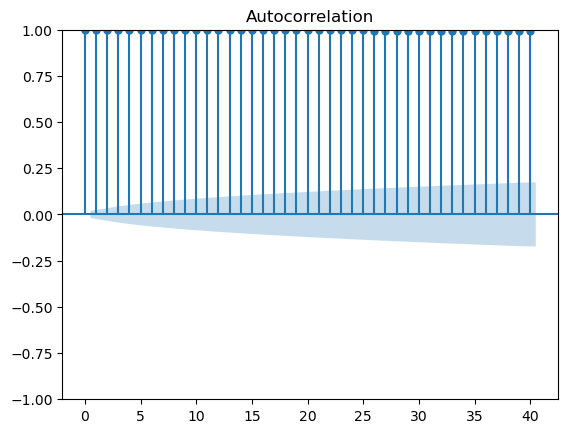

In [18]:
plot_acf(data)

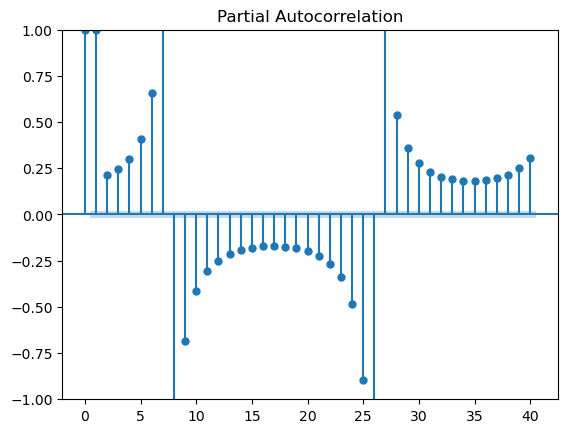

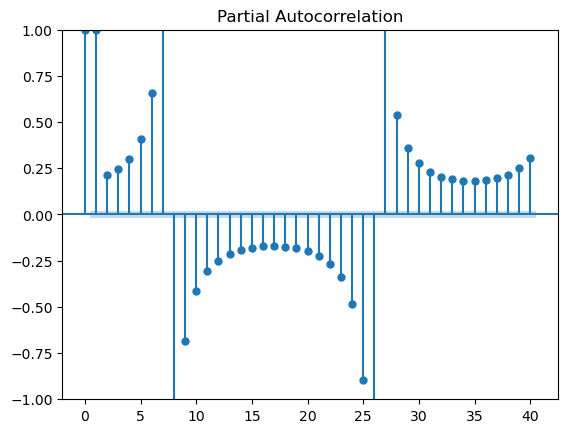

In [19]:
plot_pacf(data)

In [20]:
data_diff=np.diff(data['hourly_bandwidth'],n=1)

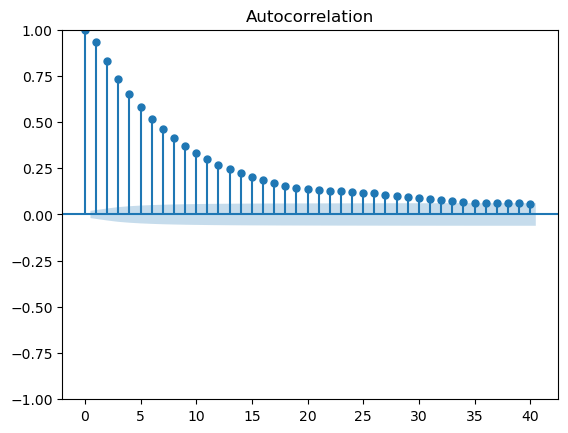

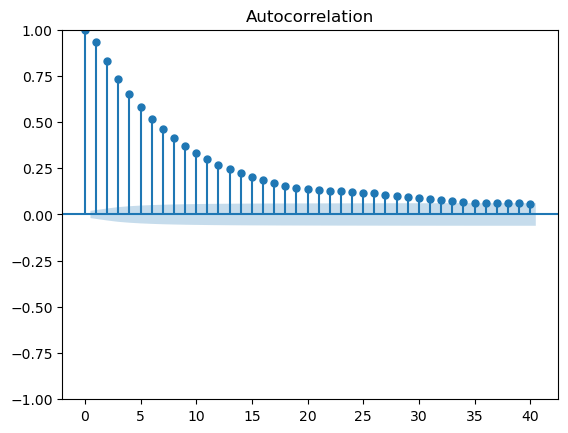

In [21]:
plot_acf(data_diff)

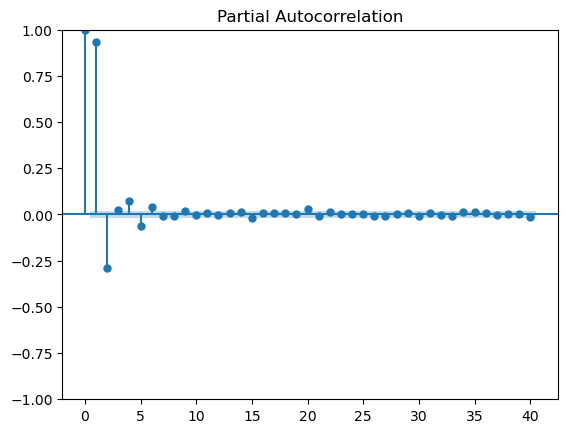

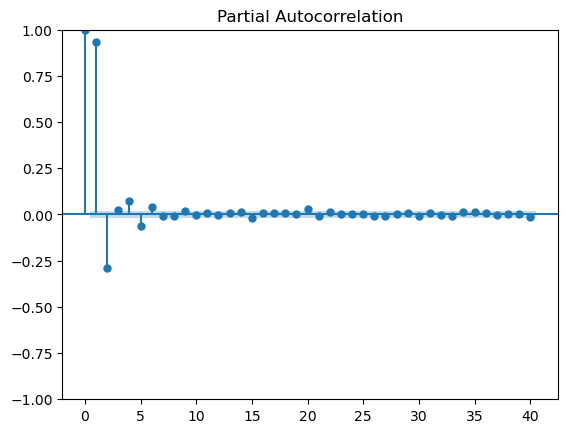

In [22]:
plot_pacf(data_diff)

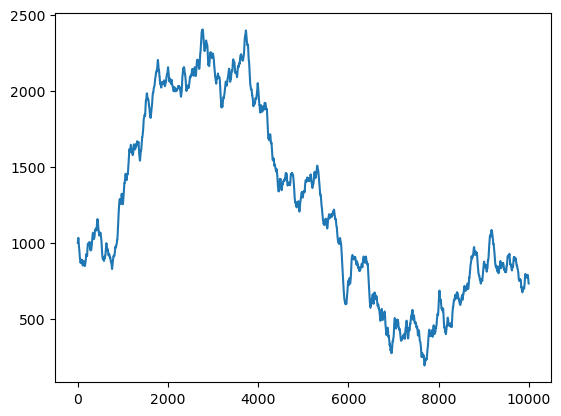

In [23]:
plt.plot(data)

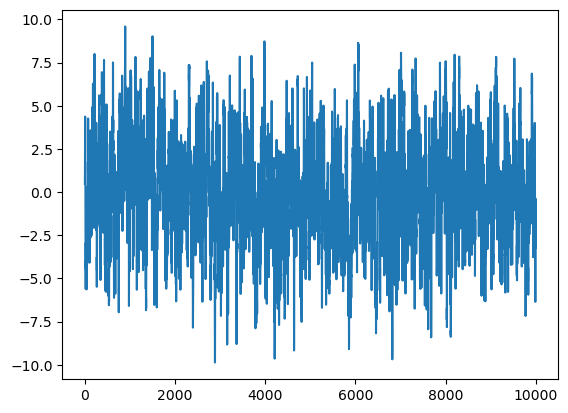

In [24]:
plt.plot(data_diff)

In [25]:
test_res=adfuller(data_diff)
print(test_res[0],test_res[1])

-20.694853863789017 0.0


In [26]:
train=data_diff[:-168]
test=data_diff[-168:]

In [27]:
def choose_p_q(df,order_list):
    results=[]
    for i in order_list:
        try:
            model=SARIMAX(endog=df,order=(i[0],0,i[1]),simple_differencing=False).fit(disp=False)
            aic=model.aic
            results.append([i,aic])
        except:
            continue
    res=pd.DataFrame(results)
    res.columns=['order','aic']
    res.sort_values(by='aic',inplace=True)
    return res
        
        

In [28]:
ps=range(0,4)
qs=range(0,4)

order_list=product(ps,qs)

list_of_aic=choose_p_q(train,order_list)

list_of_aic

,order,aic
14,"(3, 2)",27991.063879
11,"(2, 3)",27991.287509
10,"(2, 2)",27991.603598
15,"(3, 3)",27993.416924
7,"(1, 3)",28003.349550
6,"(1, 2)",28051.351401
13,"(3, 1)",28071.155496
12,"(3, 0)",28095.618186
9,"(2, 1)",28097.250766
8,"(2, 0)",28098.407664


In [29]:
model=SARIMAX(train,order=(2,0,2),simple_differencing=False).fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1397.704
Date:                Tue, 30 May 2023   AIC                           2801.408
Time:                        14:53:37   BIC                           2816.131
Sample:                             0   HQIC                          2807.004
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3103      0.032      9.572      0.000       0.247       0.374
ma.L1          0.9203      0.014     66.415      0.000       0.893       0.948
sigma2         0.9560      0.042     22.825      0.0

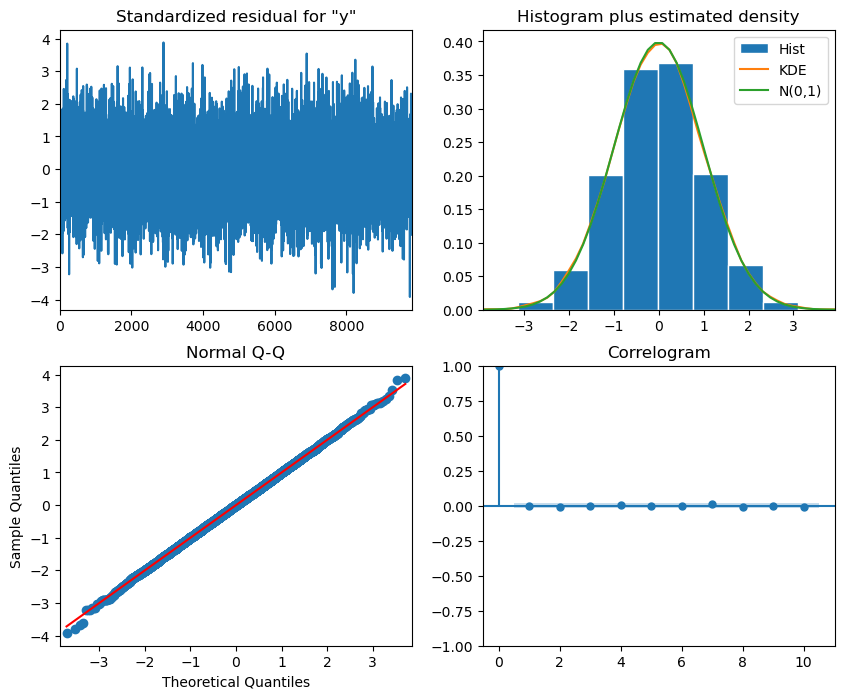

In [30]:
model.plot_diagnostics(figsize=(10, 8));

In [31]:
residuals = model.resid
val= acorr_ljungbox(residuals, np.arange(1, 11, 1))
val

,lb_stat,lb_pvalue
1,0.042190,0.837257
2,0.418364,0.811247
3,0.520271,0.914416
4,0.850554,0.931545
5,0.850841,0.973678
6,1.111754,0.981019
7,2.124864,0.952607
8,3.230558,0.919067
9,3.248662,0.953615
10,3.588289,0.964015


In [37]:
def forecasting(train_len,test_len,window,df,type_):
    total_len=train_len+test_len
    
    if type_=='mean':
        res=[]
        for i in range(train_len,total_len,window):
            m_val=np.mean(df[:i].values)
            res.extend(m_val for _ in range(window))
        return res
    elif type_=='last':
        res=[]
        for i in range(train_len,total_len,window):
            l_val=np.mean(df[:i].iloc[-1].values[0])
            res.extend(l_val for _ in range(window))
        return res
    else:
        res=[]
        for i in range(train_len,total_len,window):
            model=SARIMAX(df[:i],order=(2,0,2),simple_differencing=False).fit(disp=False)
            predictions = model.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            res.extend(oos_pred)
        return res

In [38]:
train_len=len(train)
test_len=len(test)
window=2

df_diff_=pd.DataFrame({'diff':data_diff})
df_diff_train=pd.DataFrame({'diff':train})
df_diff_test=pd.DataFrame({'actual':test})

l=forecasting(train_len,test_len,window,df_diff_,'last')
m=forecasting(train_len,test_len,window,df_diff_,'mean')
ar=forecasting(train_len,test_len,window,df_diff_,'AR')

df_diff_test['last']=l
df_diff_test['mean']=m
df_diff_test['AR']=ar

In [39]:
df_diff_test

,actual,last,mean,AR
0,-5.943995,-5.791207,-0.028214,-5.460661
1,-5.865194,-5.791207,-0.028214,-4.890626
2,-3.197066,-5.865194,-0.029410,-5.335905
3,-1.090197,-5.865194,-0.029410,-4.751731
4,0.665291,-1.090197,-0.029840,-0.375596
...,...,...,...,...
163,-0.387182,-3.250249,-0.025766,-3.107038
164,-1.639832,-0.387182,-0.026008,0.325351
165,-2.848232,-0.387182,-0.026008,0.294288
166,-2.498356,-2.848232,-0.026452,-2.975850


In [40]:
mse_mean = mean_squared_error(df_diff_test['actual'], df_diff_test['mean'])
mse_last = mean_squared_error(df_diff_test['actual'], df_diff_test['last'])
mse_ARMA = mean_squared_error(df_diff_test['actual'], df_diff_test['AR'])

print(mse_mean, mse_last, mse_ARMA)


6.306526957989325 2.2297582947733656 1.7690462114420604


In [52]:
data['diff_pred'] = pd.Series()
data['diff_pred'][train_len+1:] = data['hourly_bandwidth'].iloc[train_len+1] + df_diff_test['AR'].cumsum()

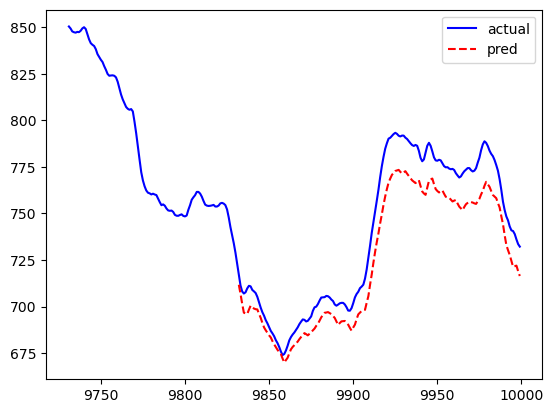

In [55]:
plt.plot(data['hourly_bandwidth'][train_len-100:],'b-',label='actual')
plt.plot(data['diff_pred'][train_len-100:],'r--',label='pred')
plt.legend()

In [56]:
mae_ARMA_undiff = mean_absolute_error(data['hourly_bandwidth'][9832:], data['diff_pred'][9832:])

print(mae_ARMA_undiff)

14.000362773294084
